In [1]:
import repath.data.datasets.bloodmucus as bloodm

dset = bloodm.validation()
dset.paths

,slide,annotation,label,tags
0,images_valid/IC-EN-02152-01.isyntax,annotations_valid/IC-EN-02152-01.tiff.txt,,
1,images_valid/IC-EN-02154-01.isyntax,annotations_valid/IC-EN-02154-01.tiff.txt,,
2,images_valid/IC-EN-02157-01.isyntax,annotations_valid/IC-EN-02157-01.tiff.txt,,
3,images_valid/IC-EN-02240-01.isyntax,annotations_valid/IC-EN-02240-01.tiff.txt,,
4,images_valid/IC-EN-02254-01.isyntax,annotations_valid/IC-EN-02254-01.tiff.txt,,
5,images_valid/IC-EN-02264-01.isyntax,annotations_valid/IC-EN-02264-01.tiff.txt,,


In [14]:
from repath.utils.paths import project_root
from joblib import load

from repath.preprocess.tissue_detection.pixel_feature_detector import TextureFeature, PixelFeatureDetector
from repath.preprocess.tissue_detection import TissueDetectorGreyScale, SizedClosingTransform, FillHolesTransform

experiment_name = "bloodmucus_sigma0_nn_sampsize"
experiment_root = project_root() / "experiments" / experiment_name

sub_exp_root = experiment_root / "mask_cols_morph"

clf = load(sub_exp_root / 'nn.joblib')

features_list = [TextureFeature()]
pixel_feature_detector = PixelFeatureDetector(features_list=features_list, sigma_min = 1, sigma_max = 2, raw=True)

morphology_transform1 = SizedClosingTransform(level_in=feature_level)
morphology_transform2 = FillHolesTransform(level_in=feature_level)
morphology_transforms = [morphology_transform1, morphology_transform2]
tissue_detector = TissueDetectorGreyScale(grey_level=0.85, morph_transform = morphology_transforms)

output_level = 7

feature_level = 4

morph = True

In [11]:
from repath.preprocess.tissue_detection.blood_mucus_rework import get_slides_annots, set_background_to_white
from repath.postprocess.blood_mucus_results import get_annot_areas

# read in slides and for extracting features
thumbz, annotz = get_slides_annots(dset, feature_level, default_label="background")
filtered_thumbz = set_background_to_white(thumbz, tissue_detector)

# read in slides and annotations for plotting and calculating results
thumbz_out, annotz_out = get_slides_annots(dset, output_level, default_label="background")
filtered_thumbz_out = set_background_to_white(thumbz_out, tissue_detector)
annot_areaz = get_annot_areas(dset, output_level)

# settings for pooling from feature level to output level
patch_level = 0
patch_size = 2**output_level
stride = patch_size
scale_factor = 2 ** (feature_level - patch_level)
kernel_size = int(patch_size / scale_factor)
label_level_stride = int(stride / scale_factor)

In [29]:
import numpy as np

from repath.utils.convert import to_frame_with_locations

stride = 2 ** output_level

dfs_out = []

for idx, thumb in enumerate(filtered_thumbz):
    print(idx, "of", len(filtered_thumbz))
    # get features from pixel feature detector (shape is thumb rows, thumb columns, nfeatures)
    features = pixel_feature_detector(thumb)
    # flatten so shape is 2d (thumb rows * thumb columns, nfeatures)
    features_reshape = features.reshape(-1, features.shape[-1])

    # predict from features
    output = clf.predict(features_reshape)

    # reshape back to thumb shape
    labels_image = np.reshape(output, (thumb.shape[:-1]))

    # use tissue detector to set background values to zero
    tissue_mask = tissue_detector(thumb)
    filtered_labels_image = np.where(np.logical_not(tissue_mask), 0, labels_image)

    # change to output size by pooling values 
    output_labels = pool_blood_mucus(filtered_labels_image, kernel_size, label_level_stride, 0)
    # output labels, background = 0, tissue = 1, blood or mucus = 2

    # get output thumbnail
    thumb_out = thumbz_out[idx]
    # adjust size sometimes pixel size off by one ### HACK
    if thumb_out.shape[0:2] != output_labels.shape:
        output_labels = output_labels[0:thumb_out.shape[0], 0:thumb_out.shape[1]]

    # colour annotations for output
    annot_out = annotz_out[idx]
    # change labels of pathologist annotation so blood and mucus classes as grouped together
    annot_out_ed = np.where(annot_out > 1, 2, annot_out)

    # calculate numeric results        
    # get area which is fuly annotated and calculate position
    annot_area = annot_areaz[idx]
    pixvals = np.where(annot_area > 0)
    minrw = min(pixvals[0])
    maxrw = max(pixvals[0])+1
    mincl = min(pixvals[1])
    maxcl = max(pixvals[1])+1

    if morph:
        # fill holes and expand mask for tissue
        tiss_mask = output_labels == 1
        closing_trans = SizedClosingTransform(level_in=output_level)
        fill_holes = FillHolesTransform(level_in=output_level)
        tiss_mask = fill_holes(tiss_mask)
        tiss_mask = closing_trans(tiss_mask)
        output_labels = np.where(tiss_mask, tiss_mask, output_labels)
        
    df = to_frame_with_locations(output_labels, "label")
    df.row *= stride
    df.column *= stride
    df = df.rename(columns={"row": "y", "column": "x"})
    df = df.reindex(columns=["x", "y", "label"])
    
    df_annot = to_frame_with_locations(annot_out_ed, "annotation")
    df["annotation"] = df_annot["annotation"]
    df["path"] = dset.paths.slide.iloc[idx]
    
    miny = minrw * stride
    maxy = maxrw * stride
    minx = mincl * stride
    maxx = maxcl * stride
        
    df = df[df.x>=minx]
    df = df[df.x<=maxx]
    df = df[df.y>=miny]
    df = df[df.y<=maxy]

    dfs_out.append(df)

0 of 6
1 of 6
2 of 6
3 of 6
4 of 6
5 of 6


In [31]:
import pandas as pd
all_patches = pd.concat(dfs_out)

In [35]:
tissue_tissue_patches = all_patches[np.logical_and(all_patches.label == 1, all_patches.annotation == 1)]
tissue_bloodm_patches = all_patches[np.logical_and(all_patches.label == 1, all_patches.annotation == 2)]
bloodm_tissue_patches = all_patches[np.logical_and(all_patches.label == 2, all_patches.annotation == 1)]
bloodm_bloodm_patches = all_patches[np.logical_and(all_patches.label == 2, all_patches.annotation == 2)]

In [57]:
npatches = 2750
tt_patches = tissue_tissue_patches.sample(n=npatches, axis=0)
tb_patches = tissue_bloodm_patches.sample(n=npatches, axis=0)
bt_patches = bloodm_tissue_patches.sample(n=npatches, axis=0)
bb_patches = bloodm_bloodm_patches.sample(n=npatches, axis=0)
sampled_patches = pd.concat((tt_patches, tb_patches, bt_patches, bb_patches))

In [58]:
sampled_patches = sampled_patches.sample(n=npatches*4, axis=0)
sampled_patches['patch_no'] = list(range(sampled_patches.shape[0]))
sampled_patches

,x,y,label,annotation,path,patch_no
231155,19840,49280,1,1,images_valid/IC-EN-02240-01.isyntax,0
311973,39552,44032,1,2,images_valid/IC-EN-02264-01.isyntax,1
39451,41344,8576,2,1,images_valid/IC-EN-02154-01.isyntax,2
2550,3840,2304,2,1,images_valid/IC-EN-02157-01.isyntax,3
187638,12288,26496,1,1,images_valid/IC-EN-02264-01.isyntax,4
...,...,...,...,...,...,...
551941,98176,63104,2,1,images_valid/IC-EN-02152-01.isyntax,10995
289518,40704,61696,1,1,images_valid/IC-EN-02240-01.isyntax,10996
358925,19072,50688,1,2,images_valid/IC-EN-02264-01.isyntax,10997
454894,126208,51968,2,2,images_valid/IC-EN-02152-01.isyntax,10998


In [59]:
bm_game_path = project_root() / "experiments" / "blood_mucus_game"
bm_game_path.mkdir(parents=True, exist_ok=True)
# sampled_patches.to_csv(bm_game_path / "sampled_patches", index=False)

In [60]:
import cv2

from repath.data.slides.isyntax import Slide
from repath.data.slides import Region

psize = 128
plevel = 0

output_dir = bm_game_path / 'patches' 
output_dir.mkdir(parents=True, exist_ok=True)

for sl_idx, sl_group in sampled_patches.groupby('path'):
    with Slide(project_root() / 'data' / 'icaird_blood' / sl_idx) as slide:
        print(f"Writing patches for {sl_idx}")
        for row in sl_group.itertuples():
            # read the patch image from the slide
            region = Region.patch(row.x, row.y, psize, plevel)
            image = slide.read_region(region)

            # write out the slide
            patch_filename = str(row.patch_no) + ".png"
            image_path = output_dir / patch_filename
            image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
            cv2.imwrite(str(image_path), np.array(image))

Writing patches for images_valid/IC-EN-02152-01.isyntax
Writing patches for images_valid/IC-EN-02154-01.isyntax
Writing patches for images_valid/IC-EN-02157-01.isyntax
Writing patches for images_valid/IC-EN-02240-01.isyntax
Writing patches for images_valid/IC-EN-02254-01.isyntax
Writing patches for images_valid/IC-EN-02264-01.isyntax


In [68]:
from PIL import Image

n = 0

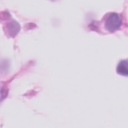

In [95]:
n +=1
Image.open(output_dir / (str(n) + ".png"))
